In [75]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from scipy.io import mmread, mmwrite
import matplotlib.pyplot as plt
# from scipy import sparse
import plotly.express as px
import random
import math
import seaborn as sns

In [40]:
df = pd.read_csv("animationData.csv")

In [41]:
df = df.drop(columns=(["LAD1_2", "LAD3_4"]))

### Need to assign each LAD to either North or South

Use the region to say:
East of England, South West, South East, and London constitute 'South'.

In [42]:
LAD_Region_lookup = pd.read_csv("LAD_Region_lookup.csv")

In [43]:
df = df.merge(LAD_Region_lookup, left_on="LAD", right_on="LAD11NM", how="left")

In [44]:
df["NorthIndicator"] = np.where( (df["RGN11NM"] == "London") | (df["RGN11NM"] == "South West") | (df["RGN11NM"] == "South East") | (df["RGN11NM"] == "East of England"), 0, 1) 

This was when I was using longituude to define N/S as I didn't know what to do.

In [45]:
df = df.rename(columns={"LAD_x": "LAD"})
df = df.drop(columns=(["LAD_y", "Unnamed: 0", "LAD11NM"]))

In [46]:
df.head()

,dim1,dim2,dim3,dim4,year,Xscaled,Yscaled,LAD,col,index,LAD11CD,RGN11CD,RGN11NM,NorthIndicator
0,-0.107843,1.474271e-01,-0.085918,0.067565,2005,0.784615,0.289551,Westminster,#C8334A,179,E09000033,E12000007,London,0
1,-0.075522,5.805172e-02,-0.039126,-0.008742,2005,0.795622,0.282016,Southwark,#CB3348,321,E09000028,E12000007,London,0
2,-0.060125,-3.298477e-07,-0.026208,0.007644,2005,0.800248,0.290575,Tower Hamlets,#CC334A,171,E09000030,E12000007,London,0
3,-0.073188,5.153974e-02,-0.043687,-0.025779,2005,0.777226,0.285945,Hammersmith and Fulham,#C63349,296,E09000013,E12000007,London,0
4,-0.055033,-6.681403e-03,-0.044061,0.006443,2005,0.780755,0.287109,Kensington and Chelsea,#C73349,297,E09000020,E12000007,London,0


In [47]:
# a = np.where(df["Yscaled"] > 0.5) # longitude value is more than halfway up the range of longitude values in our data

In [48]:
# df.loc[a]

In [49]:
# df["NorthIndicator"] = np.where(df["Yscaled"] > 0.5, 1, 0) 
# 1 for North, 0 for South

In [50]:
years = df["year"].unique()
years 

array([2005, 2006, 2007, 2008, 2009, 2010])

### 04/10/2022

In [51]:
# how many LADs are in the north
n = df[(df["year"]==2005) & (df["NorthIndicator"]==1)].shape[0]
# how many LADs are in the south
s = df[(df["year"]==2005) & (df["NorthIndicator"]==0)].shape[0]

n

164

In [52]:
d = 4

In [53]:
earlyYears = years[0:3] # 2005-2007
lateYears = years[3:6]  # 2008-2010

In [54]:
mean_diff_early = []
mean_diff_late = []

In [55]:
# make a column that is 1 if the year is an "early year"
df["EarlyIndicator"] = np.where( (df["year"] == earlyYears[0]) | (df["year"] == earlyYears[1]) | (df["year"] == earlyYears[2]), 1, 0) 
earlyNorthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 1) ]
earlySouthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 0) ]
lateNorthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 1) ]
lateSouthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 0) ]

In [56]:
# calculate values of mean_diff_early_i for all i, i.e. all PCs, and store them in order in a vector
# same for mean_diff_late_i

for i in range(0,d):
    valEarly = (1/3*n) * sum( earlyNorthdf.iloc[: ,i])  -  (1/3*s) * sum( earlySouthdf.iloc[: ,i])
    valLate = (1/3*n) * sum( lateNorthdf.iloc[: ,i])  -  (1/3*s) * sum( lateSouthdf.iloc[: ,i])
    mean_diff_early.append(valEarly)
    mean_diff_late.append(valLate)

In [57]:
# calculate T_PC_i
T_PC = np.subtract(mean_diff_early, mean_diff_late)

# length d vector of the subtracted values
T_PC

array([-30.00939698,  -1.16528904,  52.48779058, 139.49646794])

In [58]:
T_full_obs = sum(T_PC**2) # this is T_obs
T_obs = T_full_obs # incase I type wrong thing
T_full_obs

23116.154534142952

#### Permute assignments of LADs into before/after independently

If the null hypothesis says that time doesn't matter, the labelling of columns into positions shouldn't matter. So we can permute the assignments.
Each LAD is counted exactly 3 times in the early/late groups, which we might label A and B when permuting to avoid confusion. Which groups the LADs columns are assigned to are done **independently** for each LAD.

In [59]:
ladslist = pd.read_csv("LADS_list.csv", header=None)

ladslist = ladslist[1]
ladslist = list(ladslist)
len(ladslist)

348

In [60]:
# df[(df["LAD"]=="Leeds") | (df['LAD']=="York")]

### Put it all together in a loop that iterates P times, and stores P items in a `T_full_p_list` item. 

In [61]:
rand_ones = np.array([0,0,0,1,1,1])
df["A_indicator"] = 0

T_full_p_list = []
P = 5000

# for the individual PCs
T_PC_p_table = pd.DataFrame(columns=['dim1','dim2','dim3','dim4'])

In [64]:
for p in range(P):

    for lad in ladslist:
        # to pick 3 timepoints at random for group A
        random.shuffle(rand_ones)
        # populates the "A_indicator" column
        df.loc[df["LAD"] == lad,"A_indicator"] = rand_ones

    # split the data into the 4 groups (made up of 2 binary labels, 2*2 = 4)
    A_Northdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 1) ]
    A_Southdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 0) ]
    B_Northdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 1) ]
    B_Southdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 0) ]

    # length d vectors of the difference between the mean locations of the North and South for the 2 groups, A and B 
    mean_diff_A_p = []  #A is early, B is late
    mean_diff_B_p = []
    # calculate values of mean_diff_A_i for all i, i.e. all PCs, and store them in order in a vector
    # same for mean_diff_B_i
    for i in range(0,d):
        valA = (1/3*n) * sum( A_Northdf.iloc[: ,i])  -  (1/3*s) * sum( A_Southdf.iloc[: ,i])
        valB = (1/3*n) * sum( B_Northdf.iloc[: ,i])  -  (1/3*s) * sum( B_Southdf.iloc[: ,i])
        mean_diff_A_p.append(valA)
        mean_diff_B_p.append(valB)

    # calculate T_PC_i_p
    T_PC_p = np.subtract(mean_diff_A_p, mean_diff_B_p)

    T_full_p = sum(T_PC_p**2) # this is T_obs

    # values for all dimensions statistic 
    T_full_p_list.append(T_full_p)
    
    # values for individual dimension statistic
    T_PC_p_table.loc[p,:] = T_PC_p

In [65]:
counter = 0
for p in range(P):
    if T_full_p_list[p] > T_obs:
        counter += 1
    else: 
        counter = counter

In [66]:
counter

19

In [67]:
max(T_full_p_list)

40014.08471003582

In [68]:
# because we consider:
# p-value = (1/(P+1)) #test statistics >= T_obs 
# where T_obs and T_p are all considered.
(counter+1)/(P+1)

0.003999200159968006

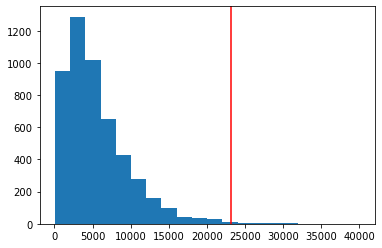

In [69]:
plt.hist(T_full_p_list, bins=20)
plt.axvline(T_obs,color='red')

This is across all d=4 embedding dimensions. We should split this out now to have 4 T_obs, one for each PC, and then get P replicates of T_PC_i

#### Testing if time matters in each of the 4 dimensions independently
I think we can do this as the dimensions are orthogonal

In [70]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table.iloc[p , dim] > T_PC[dim]:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_values = [x / (P+1) for x in counters_PCs]
PC_p_values

[0.8926214757048591,
 0.5138972205558888,
 0.08578284343131373,
 0.0003999200159968006]

In [71]:
T_PC

array([-30.00939698,  -1.16528904,  52.48779058, 139.49646794])

In [72]:
T_PC_p_table.iloc[:,0].shape

(5000,)

In [73]:
# can square all the values in the `T_PC_p_table` table.
# This is to say we are looking at the value of   (mean_diff_A_p_i - mean_diff_B_p_i)**2
# when we look at row p, column i in the table

T_PC_p_table_squared = T_PC_p_table**2 # #square every value in df

Histograms for *mean_diff_A_p_i - mean_diff_B_p_i*, where there is a plot for each `i` (the dimension), and `P` counts. 

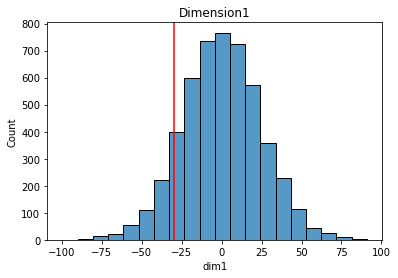

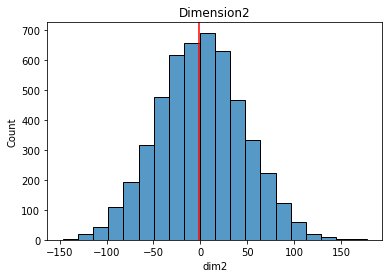

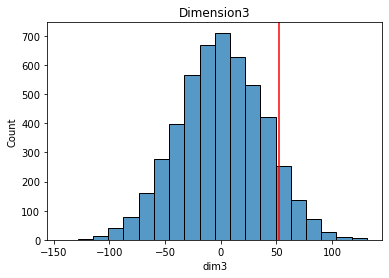

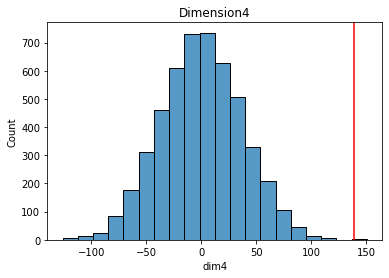

In [76]:
for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table.iloc[:,dim], bins=20)
    plt.axvline(T_PC[dim], color="red")
    ax.set_title("Dimension{}".format(dim+1))
    
    fig = ax.get_figure()

### Histograms for *(mean_diff_A_p_i - mean_diff_B_p_i)$^2$*, where there is a plot for each `i` (the dimension), and `P` counts. 

In [77]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table_squared.iloc[p , dim] > (T_PC[dim])**2:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_square_values = [x / (P+1) for x in counters_PCs]
PC_p_square_values

[0.21355728854229153,
 0.9776044791041791,
 0.17436512697460507,
 0.0003999200159968006]

Tells us at the 5% significance level, we can see that only a significant change for PC4 in that we see a change between the 
**early** years (2005-2007) and the **late** years (2008-2010).

* PC3 is latitude (East-West)
* PC4 is longitude (North-South)

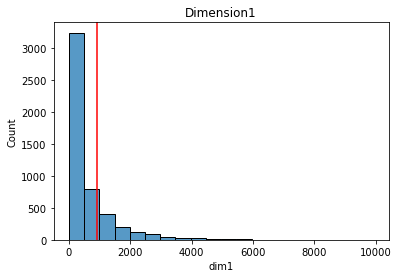

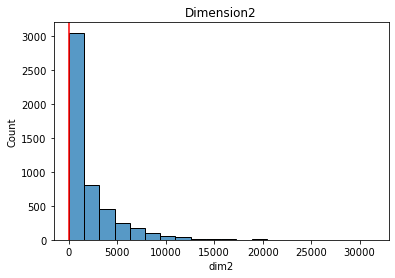

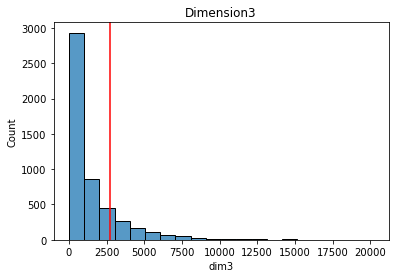

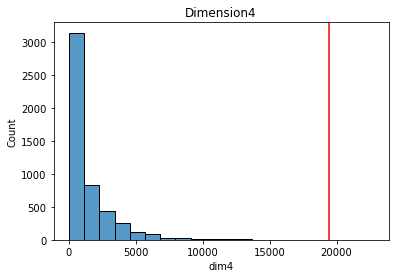

In [79]:
# squared values of distance between mean diff in groups A and B

for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table_squared.iloc[:,dim], bins=20)
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title("Dimension{}".format(dim+1))
    
    fig = ax.get_figure()